In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from fundseg.utils.colors import CLASSES_COLORS, CMAP, COLORS

warnings.simplefilter(action="ignore", category=FutureWarning)

warnings.filterwarnings("ignore")


In [2]:
datasets = ["FGADR", "RETLES", "DDR", "MESSIDOR", "IDRID"]
lesions = ["Cotton_Wool_Spot", "Exudates", "Hemorrhages", "Microaneurysms"]

stats_idrid = pd.read_pickle("idrid_global.pkl")
stats_messidor = pd.read_pickle("messidor_global.pkl")
stats_fgadr = pd.read_pickle("fgadr_global.pkl")
stats_retles = pd.read_pickle("retles_global.pkl")
stats_ddr = pd.read_pickle("ddr_global.pkl")

stats_idrid["Dataset"] = "IDRID"
stats_messidor["Dataset"] = "MESSIDOR"
stats_fgadr["Dataset"] = "FGADR"
stats_retles["Dataset"] = "RETINAL_LESIONS"
stats_ddr["Dataset"] = "DDR"


all_dfs = dict(FGADR=stats_fgadr, RETLES=stats_retles, DDR=stats_ddr, MESSIDOR=stats_messidor, IDRID=stats_idrid)

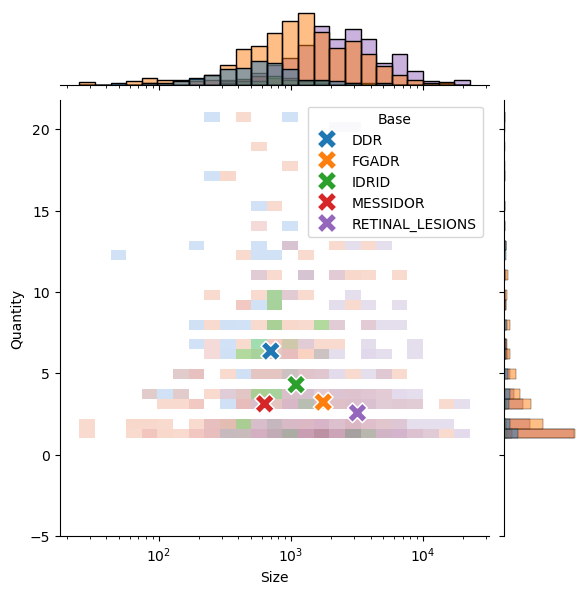

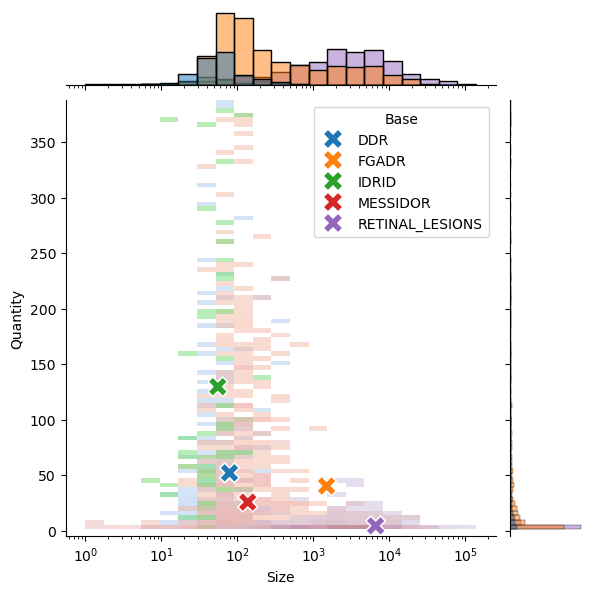

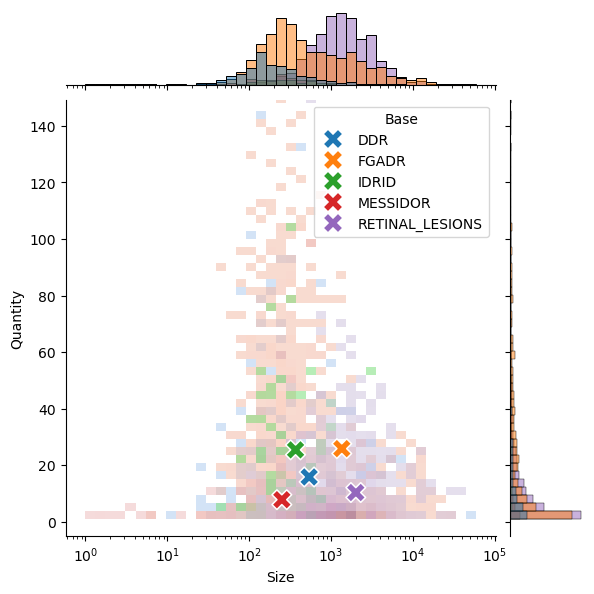

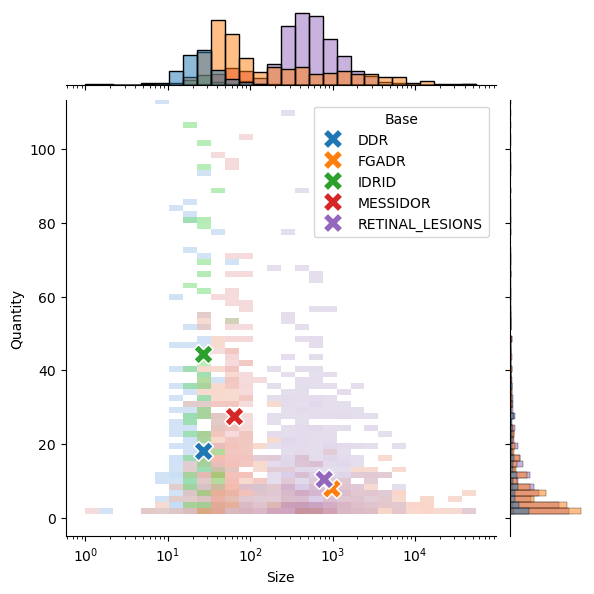

In [3]:
def get_lesions_size_as_dict(dfs, lesion):
    return {k: np.concatenate(data[f"{lesion}_size"].values) for k, data in dfs.items()}


lesions_size = get_lesions_size_as_dict(all_dfs, lesions[0])


def dataframe_from_lesions_size(lesions_size):
    dfs = []
    for k, v in lesions_size.items():
        df = pd.DataFrame.from_dict(dict(lesion_size=v, Datasett=k))
        dfs.append(df)
    return pd.concat(dfs)


def average_count_number_image(df, col):
    mean_values = [np.mean(_) for _ in df[col].values]
    count_values = [len(_) for _ in df[col].values]
    return pd.DataFrame(dict(Size=mean_values, Quantity=count_values, Base=df["Dataset"].values))


for l in lesions:
    pds = pd.concat([average_count_number_image(df, f"{l}_size") for df in all_dfs.values()])
    pds.dropna(axis=0, inplace=True)
    pds.sort_values(by="Base", inplace=True)

    x_limit = np.percentile(pds["Size"], 99.95)
    y_limit = np.percentile(pds["Quantity"], 99.5)

    g = sns.jointplot(
        pds,
        x="Size",
        y="Quantity",
        hue="Base",
        log_scale=(True, False),
        kind="hist",
        fill=True,
        joint_kws=dict(alpha=0.5),
    )
    # g.ax_joint.set_xlim(-2000, x_limit)
    g.ax_joint.set_ylim(-5, y_limit)
    # g.plot_joint(sns.kdeplot, log_scale=(True, False), hue="Base", kind="kde", levels=2)
    pd_mean = pds.groupby(["Base"]).mean()
    pd_mean.sort_index(inplace=True)
    sns.scatterplot(x=pd_mean["Size"], y=pd_mean["Quantity"], hue=pd_mean.index, marker="X", s=2e2)
    plt.savefig(f"distributions/{l}.png")
    plt.show()


In [4]:
for l in lesions:
    pds = pd.concat([average_count_number_image(df, f"{l}_size") for df in all_dfs.values()])
    pds.dropna(axis=0, inplace=True)
    pds.sort_values(by="Base", inplace=True)

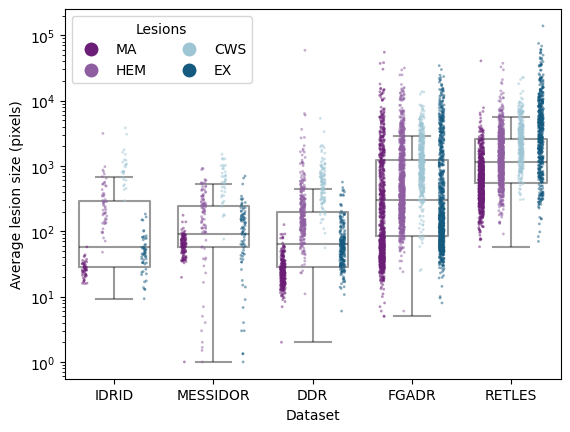

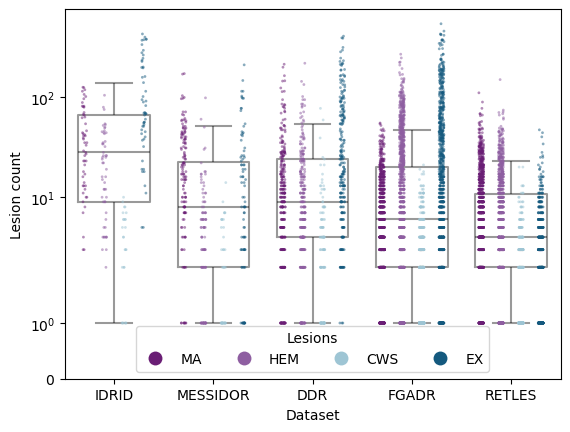

In [130]:
all_pds = []
for l in lesions:
    pds = pd.concat([average_count_number_image(df, f"{l}_size") for df in all_dfs.values()])
    pds["Lesion"] = l.replace("Cotton_Wool_Spot", "CWS")
    pds["Lesion"] = pds["Lesion"].replace("Exudates", "EX")
    pds["Lesion"] = pds["Lesion"].replace("Hemorrhages", "HEM")
    pds["Lesion"] = pds["Lesion"].replace("Microaneurysms", "MA")
    pds["Dataset"] = pds["Base"].replace("RETINAL_LESIONS", "RETLES")
    all_pds.append(pds)
all_pds = pd.concat(all_pds)
all_pds.dropna(axis=0, inplace=True)
order = ["IDRID", "MESSIDOR", "DDR", "FGADR", "RETINAL_LESIONS"]


def sort_func(x):
    return x.map(lambda y: order.index(y))


all_pds.sort_values(by="Base", inplace=True, key=sort_func)

palette = {
    "EX": CLASSES_COLORS["EXUDATES"],
    "CWS": CLASSES_COLORS["COTTON_WOOL_SPOT"],
    "HEM": CLASSES_COLORS["HEMORRHAGES"],
    "MA": CLASSES_COLORS["MICROANEURYSMS"],
}
sns.boxplot(
    data=all_pds,
    x="Dataset",
    y="Size",
    # hue="Lesion",
    width=0.8,
    dodge=0.4,
    fill=False,
    gap=0.1,
    showfliers=False,
    boxprops=dict(alpha=0.4, color="black"),
    medianprops=dict(alpha=0.4, color="black"),
    whiskerprops=dict(alpha=0.4, color="black"),
    capprops=dict(alpha=0.4, color="black"),
)

axes = sns.stripplot(
    data=all_pds,
    x="Dataset",
    y="Size",
    hue="Lesion",
    dodge=True,
    alpha=0.5,
    jitter=True,
    size=2,
    legend=True,
    palette=palette,
)
handles, labels = axes.get_legend_handles_labels()
for handle in handles:
    if isinstance(handle, plt.Line2D):
        handle.set_alpha(1)
        handle.set_markersize(10)  # Increase the marker size in the legend

plt.legend(handles, labels, loc="upper left", ncol=2, title="Lesions")
# Change the y label
axes.set_ylabel("Average lesion size (pixels)")
axes.set_yscale("log")
plt.show()


sns.boxplot(
    data=all_pds,
    x="Dataset",
    y="Quantity",
    # hue="Lesion",
    width=0.8,
    dodge=0.4,
    fill=False,
    gap=0.1,
    showfliers=False,
    boxprops=dict(alpha=0.4, color="black"),
    medianprops=dict(alpha=0.4, color="black"),
    whiskerprops=dict(alpha=0.4, color="black"),
    capprops=dict(alpha=0.4, color="black"),
)

axes = sns.stripplot(
    data=all_pds,
    x="Dataset",
    y="Quantity",
    hue="Lesion",
    dodge=True,
    alpha=0.5,
    jitter=True,
    size=2,
    legend=True,
    palette=palette,
)
handles, labels = axes.get_legend_handles_labels()
for handle in handles:
    if isinstance(handle, plt.Line2D):
        handle.set_alpha(1)
        handle.set_markersize(10)  # Increase the marker size in the legend

plt.legend(handles, labels, loc="lower center", ncol=4, title="Lesions")
# Change the y label
axes.set_ylabel("Lesion count")
axes.set_yscale("symlog")
axes.set_ylim(0, all_pds["Quantity"].max() * 1.4)
plt.show()


In [104]:
CLASSES_COLORS

{'BG': '#000000',
 'COTTON_WOOL_SPOT': '#9ec5d4',
 'EXUDATES': '#14597e',
 'HEMORRHAGES': '#8e5ea1',
 'MICROANEURYSMS': '#6a1e75'}